In [1]:
import pandas as pd
import scipy as sp
import numpy as np

from abtools.bayesian import LognormalARPUABModel

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('data.csv')

In [4]:
a_conversion = (data.query('abgroup == "control"')['revenue'] > 0) * 1
a_revenue = data.query('revenue > 0 and abgroup == "control"')['revenue']
b_conversion = (data.query('abgroup == "test"')['revenue'] > 0) * 1
b_revenue = data.query('revenue > 0 and abgroup == "test"')['revenue']

In [19]:
data.groupby('abgroup')['revenue'].mean()

abgroup
control    1.078714
test       1.087932
Name: revenue, dtype: float64

In [18]:
a_revenue.mean()

21.00896393197533

In [17]:
b_revenue.mean()

21.388920173617667

In [5]:
model = LognormalARPUABModel(
    {'revenue': a_revenue, 'conversion': a_conversion},
    {'revenue': b_revenue, 'conversion': b_conversion}
)

/home/ivba/.local/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
/home/ivba/.local/lib/python3.5/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [6]:
model.fit()

         Current function value: 816440.047229
         Iterations: 20
         Function evaluations: 115
         Gradient evaluations: 103


100%|██████████| 10000/10000 [02:35<00:00, 64.27it/s]


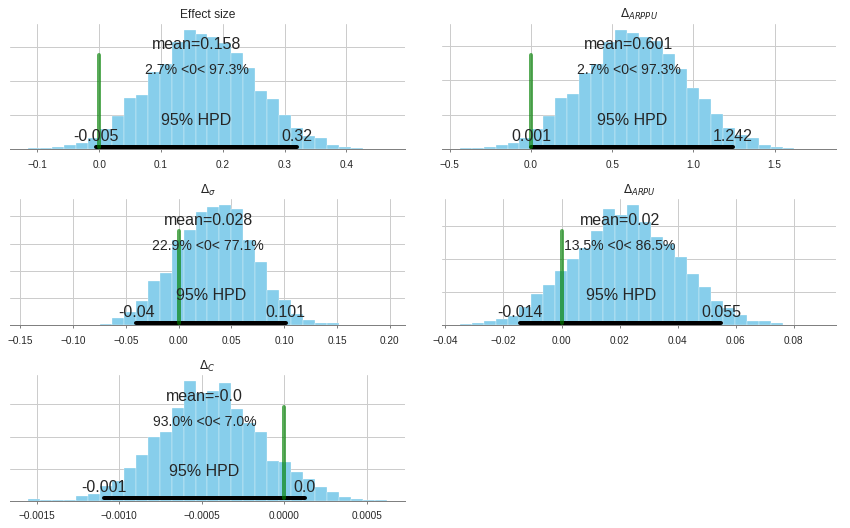

In [15]:
model.plot_deltas()
plt.savefig('arpuresults.pdf')

In [13]:
import pymc3 as pm

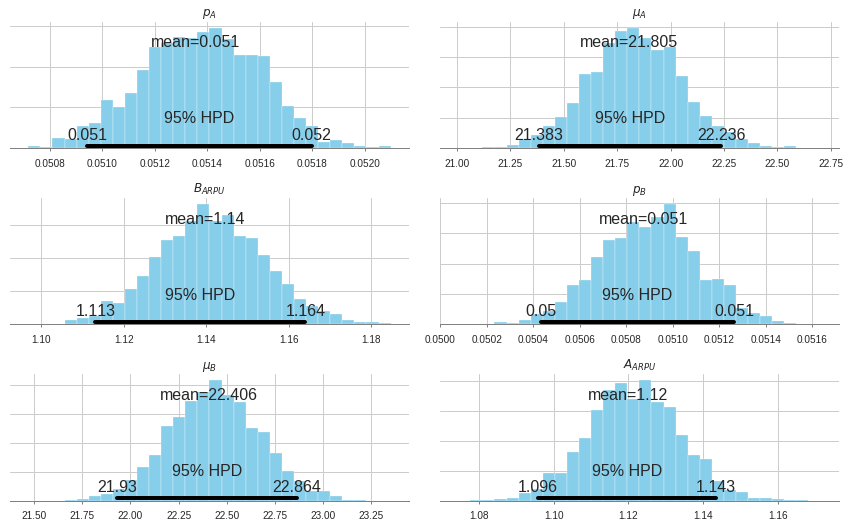

In [16]:
pm.plot_posterior(model.trace,             [
                '$p_A$', '$p_B$',
                '$\\mu_A$', '$\\mu_B$',
                '$A_{ARPU}$', '$B_{ARPU}$'
            ], color='#87ceeb')
plt.savefig('arpuresults2.pdf')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0ed9c10b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7ff0ec07af60>], dtype=object)

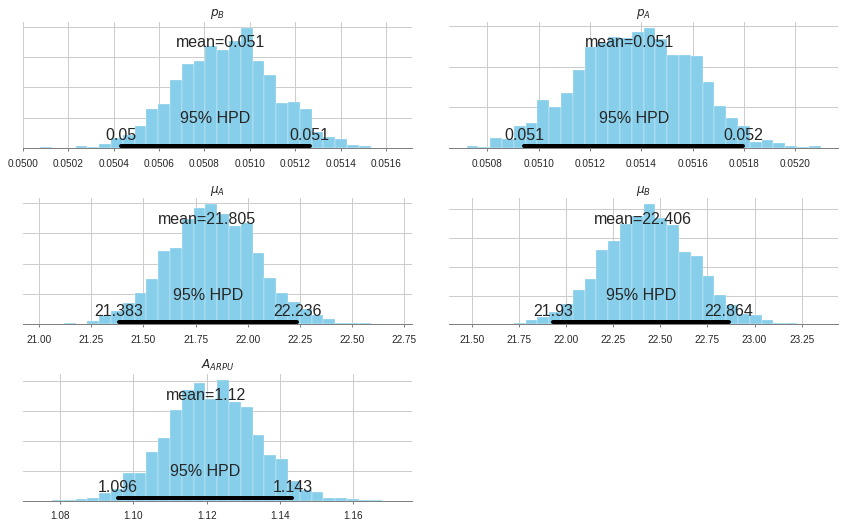

In [8]:
model.plot_params()

In [9]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\mu_{ln(A)}$,1.834232,0.006702,0.000178,1.821363,1.847546
$\mu_{ln(B)}$,1.841549,0.006921,0.000163,1.829105,1.856503
$\tau_A$,0.400701,0.002365,0.000055,0.396184,0.405397
$\tau_B$,0.394426,0.002435,0.000057,0.390120,0.399506
$\mu_A$,21.804992,0.218589,0.005799,21.383003,22.236228
$\mu_B$,22.405787,0.237652,0.005665,21.929703,22.863826
$A_{\sigma^2}$,14.419107,0.193337,0.005139,14.051460,14.806891
$B_{\sigma^2}$,14.631744,0.202587,0.004780,14.270729,15.074511
$p_A$,0.051354,0.000223,0.000006,0.050943,0.051798
$p_B$,0.050872,0.000215,0.000005,0.050433,0.051263


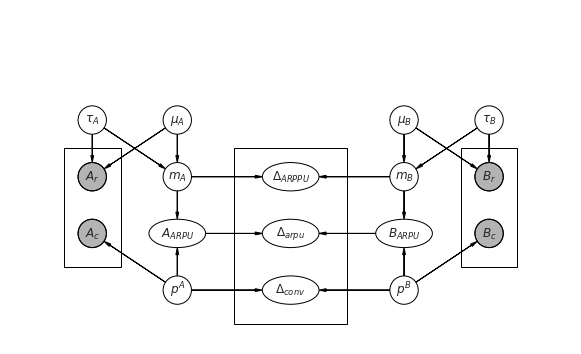

In [10]:
import daft 

# Instantiate the PGM.
pgm = daft.PGM([10, 6], origin=[0, 5])#, observed_style="inner")

# Hierarchical parameters.
pgm.add_node(daft.Node("tauA", r"$\tau_A$", 1.5, 9))

pgm.add_node(daft.Node("muA", r"$\mu_A$", 3, 9))
pgm.add_node(daft.Node("mA", r"$m_A$", 3, 8))


pgm.add_node(daft.Node("tauB", r"$\tau_B$", 8.5, 9))

pgm.add_node(daft.Node("muB", r"$\mu_B$", 7, 9))
pgm.add_node(daft.Node("mB", r"$m_B$", 7, 8))


pgm.add_node(daft.Node("A_r", r"$A_{r}$", 1.5, 8, observed=True))
pgm.add_node(daft.Node("B_r", r"$B_{r}$", 8.5, 8, observed=True))

pgm.add_node(daft.Node("pA", r"$p^A$", 3, 6))
pgm.add_node(daft.Node("pB", r"$p^B$", 7, 6))

pgm.add_node(daft.Node("A_c", r"$A_{c}$", 1.5, 7, observed=True))
pgm.add_node(daft.Node("B_c", r"$B_{c}$", 8.5, 7, observed=True))

pgm.add_node(daft.Node("A_arpu", r"$A_{ARPU}$", 3, 7, aspect=2))
pgm.add_node(daft.Node("B_arpu", r"$B_{ARPU}$", 7, 7, aspect=2))

pgm.add_node(daft.Node("d_conv", r"$\Delta_{conv}$", 5, 6, aspect=2))
pgm.add_node(daft.Node("d_arppu", r"$\Delta_{ARPPU}$", 5, 8, aspect=2))
pgm.add_node(daft.Node("d_arpu", r"$\Delta_{ARPU}$", 5, 7, aspect=2))

# Add in the edges.

pgm.add_edge("muA", "mA")
pgm.add_edge("muB", "mB")

pgm.add_edge("tauA", "mA")
pgm.add_edge("tauB", "mB")

pgm.add_edge("muA", "A_r")
pgm.add_edge("tauA", "A_r")

pgm.add_edge("muB", "B_r")
pgm.add_edge("tauB", "B_r")

pgm.add_edge('pA','A_c')
pgm.add_edge('pB','B_c')

pgm.add_edge('pA','A_arpu')
pgm.add_edge('pB','B_arpu')

pgm.add_edge('mA','A_arpu')
pgm.add_edge('mB','B_arpu')

pgm.add_edge('mA','d_arppu')
pgm.add_edge('mB','d_arppu')
pgm.add_edge('A_arpu','d_arpu')
pgm.add_edge('B_arpu','d_arpu')
pgm.add_edge('pA','d_conv')
pgm.add_edge('pB','d_conv')

# And a plate.
pgm.add_plate(daft.Plate([4, 5.5, 2, 3], shift=-0.1))
pgm.add_plate(daft.Plate([1, 6.5, 1, 2],shift=-0.1))
pgm.add_plate(daft.Plate([8, 6.5, 1, 2], shift=-0.1))

# Render and save.
pgm.render()

pgm.figure.savefig("ABpgm.pdf")
pgm.figure.savefig("ABpgm.png", dpi=350)